# Skin cancer classification challenge

**Summary :** Skin cancer classification

## Preliminaries and Imports

In [88]:
import json
import collections
from PIL import Image
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 10, 10  #default setting
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

## I. Load metadata

- **Rq : ** Datasets are quite light, can be fully loaded in a laptop memory with ease.

In [89]:
#Set all paths for data
main_path = "../ISIC-images/"
resized_folder = "../data/resized"
folders = os.listdir(main_path)

#create a target forlder for resized pictures
if not os.path.exists(resized_folder):
    os.makedirs(resized_folder)

In [90]:
%%time
temp = []
for folder in folders:
    files = os.listdir(main_path+"/"+folder)
    for element in files :
        if ".json" in element:
            with open(main_path+"/"+folder+"/"+element) as json_data:
                d = json.load(json_data)
                d["folder"]=folder
            temp.append(d)

CPU times: user 292 ms, sys: 52 ms, total: 344 ms
Wall time: 341 ms


In [91]:
def flatten_dic(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten_dic(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [92]:
%%time
#flatten the meta key:
temp = map(flatten_dic,temp)

CPU times: user 548 ms, sys: 16 ms, total: 564 ms
Wall time: 544 ms


In [93]:
#format as dataframe
meta = pd.DataFrame(temp)
meta.head()

,_id,folder,meta_acquisition_dermoscopic_type,meta_acquisition_image_type,meta_acquisition_pixelsX,meta_acquisition_pixelsY,meta_clinical_age_approx,meta_clinical_benign_malignant,meta_clinical_clin_size_long_diam_mm,meta_clinical_diagnosis,meta_clinical_diagnosis_confirm_type,meta_clinical_family_hx_mm,meta_clinical_melanocytic,meta_clinical_personal_hx_mm,meta_clinical_sex,name
0,57eea3d19fc3c12a89bb5d79,ISIC_MSK-3_1,contact non-polarized,dermoscopic,4288,2848,65.0,benign,NaN,seborrheic keratosis,histopathology,NaN,False,NaN,male,ISIC_0012469
1,57eea3e59fc3c12a89bb5ebd,ISIC_MSK-3_1,contact non-polarized,dermoscopic,4288,2848,25.0,benign,NaN,nevus,histopathology,NaN,True,NaN,male,ISIC_0012503
2,57eea3929fc3c12a89bb5842,ISIC_MSK-3_1,contact non-polarized,dermoscopic,3008,2000,45.0,benign,NaN,nevus,histopathology,NaN,True,NaN,male,ISIC_0012324
3,57eea34c9fc3c12a89bb5266,ISIC_MSK-3_1,contact non-polarized,dermoscopic,3008,2000,45.0,benign,NaN,nevus,histopathology,NaN,True,NaN,female,ISIC_0012160
4,57eea35d9fc3c12a89bb5443,ISIC_MSK-3_1,contact non-polarized,dermoscopic,3008,2000,45.0,benign,NaN,nevus,histopathology,NaN,True,NaN,male,ISIC_0012213


In [94]:
#saving file:
meta.to_csv("../data/metadata.csv",index=False)

- **Data integrity check**

In [95]:
#data integrity check
#variable types
def summaryze(df):
    summary =  pd.DataFrame()
    summary["column"] = list(df.columns)
    summary["type"] = list(df.dtypes)
    summary["nb_missing_values"] = list(df.isnull().sum())
    summary["nb_missing_values%"] = summary["nb_missing_values"]/len(df)*100
    summary.set_index("column",inplace=True)
    return summary

In [96]:
summaryze(meta)

,type,nb_missing_values,nb_missing_values%
column,,,
_id,object,0,0.000000
folder,object,0,0.000000
meta_acquisition_dermoscopic_type,object,11669,84.643842
meta_acquisition_image_type,object,0,0.000000
meta_acquisition_pixelsX,int64,0,0.000000
meta_acquisition_pixelsY,int64,0,0.000000
meta_clinical_age_approx,float64,352,2.553315
meta_clinical_benign_malignant,object,15,0.108806
meta_clinical_clin_size_long_diam_mm,float64,12251,88.865516


> ** First interpretations : **
- Image datas are stored in band_1 and band_2 as matrix
- Training set contains only 1 604 rows... warning! Data augmentation and other tricks are to be considered.
- Inc_angle nature (?)

In [97]:
#size ratio
#set(meta.meta_acquisition_pixelsX/meta.meta_acquisition_pixelsY)

# II. Colour auto croping

In [98]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
import numpy as np
import cv2
from sklearn import preprocessing
from sklearn.metrics.pairwise import euclidean_distances
from skimage import io
from sklearn.cluster import KMeans

(3872, 2592)


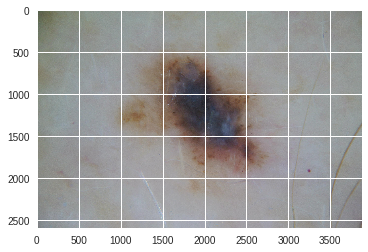

In [99]:
#resized pictures
test_picture = '../ISIC-images/ISIC_UDA-2_1/ISIC_0001103.jpg'
img = Image.open(test_picture)
plt.imshow(img)
print(img.size)

In [100]:
def kmeans_image(picture_path,k=4,resize_ratio=0.3):
    img = cv2.imread(picture_path)
    img = cv2.resize(img, (0,0), fx=resize_ratio, fy=resize_ratio)
    Z = img.reshape((-1,3))

    # convert to np.float32
    Z = np.float32(Z)

    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = k
    ret,label,center=cv2.kmeans(Z,K,None,criteria,5,cv2.KMEANS_RANDOM_CENTERS)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res = res.reshape((img.shape))

    #plt.imshow(res)
    return res,center

def kmeans_image_v2(picture_path,k=4,resize_ratio=0.3):
    img = cv2.imread(picture_path)
    img = cv2.resize(img, (0,0), fx=resize_ratio, fy=resize_ratio)
    rows = img.shape[0]
    cols = img.shape[1]
    Z = img.reshape((-1,3))
    # convert to np.float32
    Z = np.float32(Z)
    #image = image.reshape(image.shape[0]*image.shape[1],3)
    kmeans = KMeans(n_clusters = k, n_init=5, max_iter=100, tol=0.01,n_jobs = 4)
    kmeans.fit(Z)

    clusters = np.asarray(kmeans.cluster_centers_,dtype=np.uint8) 
    labels = np.asarray(kmeans.labels_,dtype=np.uint8 )  
    res = clusters[labels.flatten()]
    res = res.reshape((img.shape))
    #plt.imshow(res)
    return res,clusters



In [101]:
%%time
test,clusters = kmeans_image(test_picture,k=4,resize_ratio=0.3)

CPU times: user 11.6 s, sys: 68 ms, total: 11.7 s
Wall time: 1.61 s


In [102]:
%%time
test,clusters = kmeans_image_v2(test_picture,k=4,resize_ratio=0.3)

CPU times: user 2.34 s, sys: 108 ms, total: 2.45 s
Wall time: 1.43 s


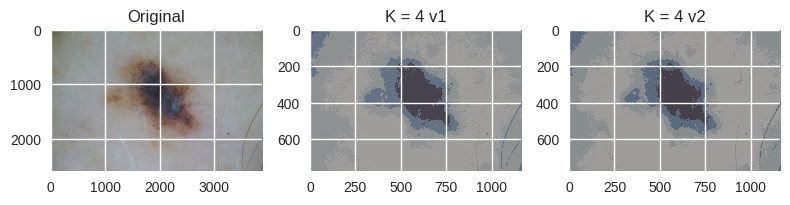

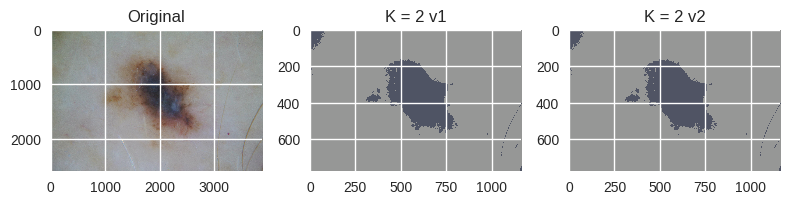

CPU times: user 28.3 s, sys: 2.44 s, total: 30.7 s
Wall time: 7.18 s


In [103]:
%%time
#plot description
plt.figure(figsize=(8,7),dpi=100)
plt.subplot(2, 3, 1)
img = Image.open(test_picture)
plt.imshow(img)
plt.title("Original")


plt.subplot(2, 3, 2)
test,clusters = kmeans_image(test_picture,k=4,resize_ratio=0.3)
plt.imshow(test)
plt.title("K = 4 v1")


#plot description
plt.subplot(2, 3, 3) 
test,clusters = kmeans_image_v2(test_picture,k=4,resize_ratio=0.3)
plt.imshow(test)
plt.tight_layout()
plt.title("K = 4 v2")
plt.show()

plt.figure(figsize=(8,7),dpi=100)
plt.subplot(2, 3, 4)
img = Image.open(test_picture)
plt.imshow(img)
plt.title("Original")


plt.subplot(2, 3, 5)
test,clusters = kmeans_image(test_picture,k=2,resize_ratio=0.3)
plt.imshow(test)
plt.title("K = 2 v1")


#plot description
plt.subplot(2, 3, 6) 
test,clusters = kmeans_image_v2(test_picture,k=2,resize_ratio=0.3)
plt.imshow(test)
plt.tight_layout()
plt.title("K = 2 v2")
plt.show()


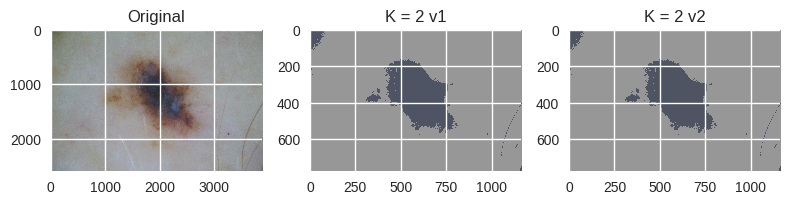

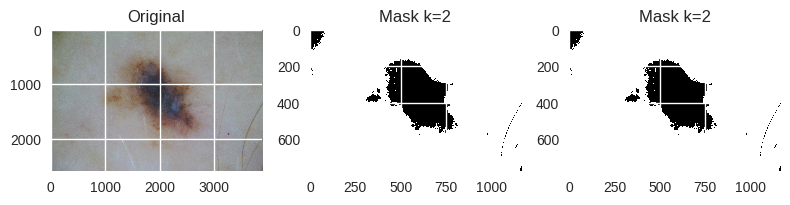

CPU times: user 23.7 s, sys: 2.3 s, total: 26 s
Wall time: 5.8 s


In [104]:
%%time
#plot description
plt.figure(figsize=(8,7),dpi=100)
plt.subplot(2, 3, 1)
img = Image.open(test_picture)
plt.imshow(img)
plt.title("Original")


plt.subplot(2, 3, 2)
test,clusters = kmeans_image(test_picture,k=2,resize_ratio=0.3)
plt.imshow(test)
plt.title("K = 2 v1")


#plot description
plt.subplot(2, 3, 3) 
test,clusters = kmeans_image_v2(test_picture,k=2,resize_ratio=0.3)
plt.imshow(test)
plt.tight_layout()
plt.title("K = 2 v2")
plt.show()

plt.figure(figsize=(8,7),dpi=100)
plt.subplot(2, 3, 4)
img = Image.open(test_picture)
plt.imshow(img)
plt.title("Original")


plt.subplot(2, 3, 5)
test,clusters = kmeans_image(test_picture,k=2,resize_ratio=0.3)
lower = clusters.min(axis = 0)
upper = lower+1
#test = cv2.GaussianBlur(test, (10,10),0)
mask = cv2.inRange(test,lower,upper)
plt.imshow(mask)
plt.title("Mask k=2")


#plot description
plt.subplot(2, 3, 6) 
test,clusters = kmeans_image_v2(test_picture,k=2,resize_ratio=0.3)
lower = clusters.min(axis = 0)
upper = lower+1
mask = cv2.inRange(test,lower,upper)
plt.imshow(mask)
plt.tight_layout()
plt.title("Mask k=2")
plt.show()


In [105]:
#https://mmeysenburg.github.io/image-processing/08-contours/
#dithering

In [110]:
#test_ = cv2.convertScaleAbs(test)
#bilateral_filtered_image = cv2.bilateralFilter(test, 5, 175, 175)
img = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(img, (5, 5), 0)
t = 5
(t, binary) = cv2.threshold(img, t, 255, cv2.THRESH_BINARY)
cnts= cv2.findContours(binary.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # RETR_EXTERNAL /RETR_TREE
contour_list = []
for contour in cnts[1]:
    #hull = cv2.convexHull(contour)
    approx = cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
    area = cv2.contourArea(contour)
    if ((len(approx) > 8) & (area > 30) ):
        contour_list.append(contour)

boxes = []
for c in contour_list:
    (x, y, w, h) = cv2.boundingRect(c)
    boxes.append((x, y, w, h))
    cv2.rectangle(mask, (x, y), (x + w, y + h), (255, 255, 255), -1)
    
#cv2.drawContours(test, contour_list,  -1, (255,0,0), 2)
#cv2.imshow('Objects Detected',test)
#plt.imshow(contours)

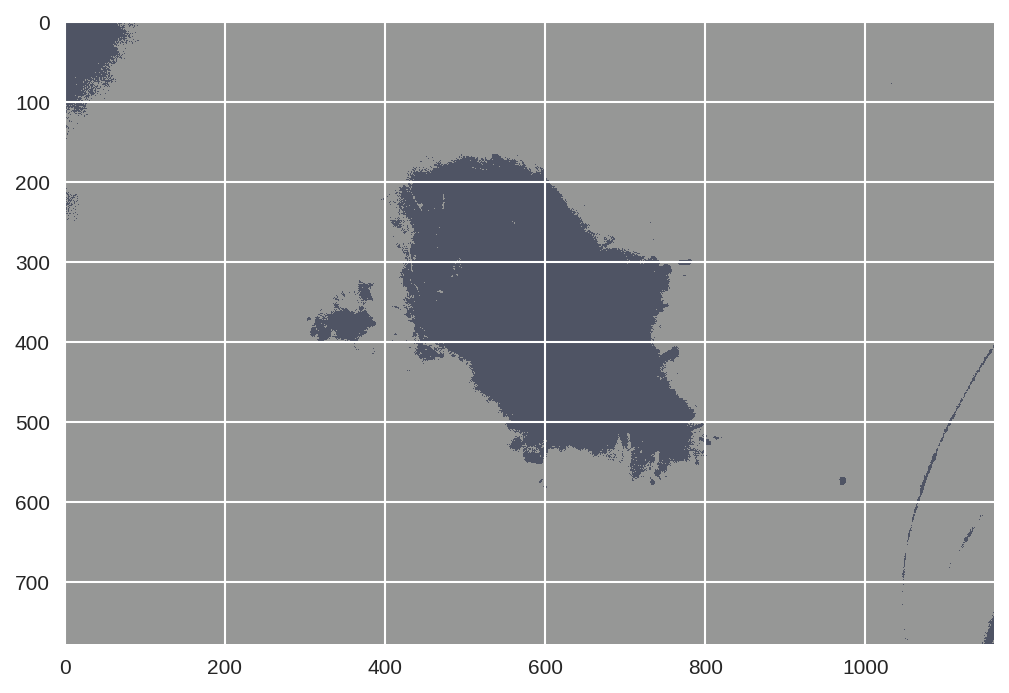

In [111]:
#plot boxes
import matplotlib.patches as patches


im = test
# Create figure and axes
fig,ax = plt.subplots(1,figsize=(8,7),dpi=150)

# Display the image
ax.imshow(im)

# Create a Rectangle patch
for (x,y,w,h) in boxes:
    rect = patches.Rectangle((x,y),w,h,linewidth=4,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

plt.show()

In [108]:
boxes

[]

In [109]:
#compute distance

In [75]:
x, y = [], []

for contour_line in contours:
    for contour in contour_line:
        x.append(contour[0][0])
        y.append(contour[0][1])

x1, x2, y1, y2 = min(x), max(x), min(y), max(y)

cropped = img[y1:y2, x1:x2]

NameError: name 'contours' is not defined

In [ ]:
%%time
#plot description
plt.figure(figsize=(8,5),dpi=100)
plt.subplot(1, 3, 1)
img = cv2.imread(test_picture)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
plt.imshow(hsv)
plt.title("Original HSV")


plt.subplot(1, 3, 2)
test = kmeans_image(test_picture,k=4,resize_ratio=0.3)
hsv = cv2.cvtColor(test, cv2.COLOR_BGR2HSV)
plt.imshow(hsv)

plt.title("Kmeans v1 HSV")


#plot description
plt.subplot(1, 3, 3) 
test = kmeans_image_v2(test_picture,k=4,resize_ratio=0.3)
hsv = cv2.cvtColor(test, cv2.COLOR_BGR2HSV)
plt.imshow(hsv)
plt.tight_layout()
plt.title("Kmeans v2 HSV")
plt.show()




# III. Treat and resize pictures

In [ ]:
%%time
#purge target folder
target  = "../data/resized/"
filelist = [ f for f in os.listdir(target) if f.endswith(".jpg") ]
for f in filelist:
    os.remove(os.path.join(target, f))

In [ ]:
def pad_center(img):
    longer_side = max(img.size)
    horizontal_padding = (longer_side - img.size[0]) / 2
    vertical_padding = (longer_side - img.size[1]) / 2
    img = img.crop(
        (
            -horizontal_padding,
            -vertical_padding,
            img.size[0] + horizontal_padding,
            img.size[1] + vertical_padding
        )
    )
    return img

In [ ]:
def resize(source,target,size):
    dirs = os.listdir(source)
    dirs = [x for x in dirs if ".jpg" in x]
    for item in dirs:
        #print(source+"/"+item)
        im = Image.open(source+"/"+item)
        #f, e = os.path.splitext(source+"/"+item)
        im = pad_center(im)
        imResize = im.resize((size,size), Image.ANTIALIAS)
        imResize.save(target+item, 'JPEG', quality=100)
    return



In [ ]:
files_list = []
for folder in folders:
    dirs = os.listdir("../ISIC-images/"+folder)
    dirs = ["../ISIC-images/"+folder+"/"+x for x in dirs if ".jpg" in x]
    files_list.append(dirs)
    
files_list = [item for sublist in files_list for item in sublist]

In [ ]:
%%time

import multiprocessing as mp
import datetime

size = 299
target = "../data/resized/"

def resize_(file_name):
    #print(source+"/"+item)
    im = Image.open(file_name)
    #f, e = os.path.splitext(file_name)
    im = pad_center(im) #tocomment if you want to distort 
    imResize = im.resize((size,size), Image.ANTIALIAS)
    item = file_name.split("/")[3]
    imResize.save(target+item, 'JPEG', quality=100)
    return 



try:
    pool = mp.Pool(processes=8)
    start_time=datetime.datetime.now()
    result = pool.map(resize_,files_list)
    pool.close()
    pool.join()
    elapsed=datetime.datetime.now()-start_time
    print("Done processing in %s" %(elapsed))
except Exception as e:
    print(e)
    pool.close()
    pool.join()
    print('Pool successfuly closed!')

In [ ]:
#resized pictures
temp = os.listdir(main_path+folder)
temp = [x for x in temp if ".jpg" in x]
img = Image.open(main_path+folder+"/"+temp[4])
plt.imshow(img)


In [ ]:
temp = os.listdir(main_path+folder)
temp = [x for x in temp if ".jpg" in x]
img = Image.open("../data/resized/"+temp[4])
plt.imshow(img)    

**Warning : ** resizing pictures deform images? except if padding

In [ ]:
#control
target  = "../data/resized/"
filelist = [ f for f in os.listdir(target) if f.endswith(".jpg") ]

len(meta) == len(filelist)

In [ ]:
print(len(meta))
print(len(filelist))

# III. Split into train and test